# Checkpoint 1: Neural networks and deep learning
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)

In this checkpoint exercise, we will use neural networks to predict the **type** of weather *given* the available ground observations. You will be using observation data from **June 2019** across all UK Met Office weather stations.

### Notes on the Dataset
* You will be using weather observation data from the UK Met Office Datapoint service
* Ground observations are made hourly at weather stations across the length of the UK 
* The data sample covers data from June 2019
* Data collections for each day starts at 6.30pm. All observation data is listed in one day blocks
* The time value column refers to the number of minutes after midnight 
* `Null` values for some features are expected (e.g. Wind Gust)
* Data import and preparation is already provided 


This week, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** Think of these as LEGO blocks; you have the ones you need but may look up how to "assemble" them.

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 9 October 2021** 
- This CP exercise sheet is divided into **6 sections**, corresponding to parts of the lecture, giving a maximum of **10 marks** in total:

| <p align='left'> Title                         | <p align='left'> Exercise nos. | <p align='left'> Number of marks |
| ------------------------------------- | ----- | --- |
| <p align='left'> 1. Conceptual questions               | <p align='left'>  1–5  | <p align='left'> 2.5 |
| <p align='left'> 2. Data preprocessing and RandomForest                | <p align='left'>  6–9  | <p align='left'> 2.5 |
| <p align='left'> 3. Neural networks in `scikit-learn`  | <p align='left'>  10–11 | <p align='left'> 1.5 | 
| <p align='left'> 4. Neural networks in `Keras`         | <p align='left'> 12–13 | <p align='left'> 2 |
| <p align='left'> 5. Regularisation                     | <p align='left'> 14–15 | <p align='left'> 1.5 |
| <p align='left'> 6. Bonus: Hyperparameter optimisation | <p align='left'> 16 | <p align='left'> 1.0 (\*bonus\*) |
| <p align='left'> **Total** | | <p align='left'> **10 + 1** |

- The total number of marks allocated for this CP is 10,
    - 1 additional mark can be given (maximimally up to 10 marks in total) for "bonus" exercise on hyperparameter optimisation. If you are pressed for time, focus on the first five sections; those are the core ones.
    - Half marks may be deducted for code legibility (i.e. very difficult to tell what you are doing), or for badly formated plots (i.e. no legends, axis labels etc.). The TAs will use their discression for this so comment code when applicable and keep relevant information in your plots.

_Note:_ You can suppress double-printing of plots from the `plot` module by either _(a)_ adding a semicolon after the function call (_i.e._ `plot.<method>(...);`), or _(b)_ by capturing the return `pyplot.Figure` object as a variable (_i.e._ `fig = plot.<method>(...)`).

## Preamble

In [250]:
# Standard import(s)
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# Suppress unnecessary ConvergenceWarnings and DeprecationWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Set a random seed variable to make workbook reproducible
seed=5
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.compat.v1.set_random_seed(seed)

# Switch off multi-threading for TensorFlow
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
K.set_session(sess)

In [251]:
# Load in the prepared weather data
obs = pd.read_csv('weather.csv')
obs.head()

,StationID,StationName,Elevation,Latitude,Longitude,Date,Time,Gust,Temperature,Visibility,WindDirection,WindSpeed,Pressure,PressureTrend,DewPoint,Humidity,Type
0,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1020,NaN,16.1,30000.0,E,8.0,1019.0,F,11.6,74.5,0
1,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1080,NaN,14.9,22000.0,E,8.0,1019.0,F,11.8,81.5,0
2,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1140,NaN,14.0,14000.0,E,6.0,1018.0,F,11.6,85.4,0
3,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1200,NaN,12.9,12000.0,ENE,2.0,1019.0,R,11.0,88.1,0
4,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1260,NaN,12.0,9000.0,E,2.0,1019.0,R,10.9,92.9,1


In [252]:
obs.shape

(106553, 17)

In [253]:
obs.describe()

,StationID,Elevation,Latitude,Longitude,Time,Gust,Temperature,Visibility,WindSpeed,Pressure,DewPoint,Humidity,Type
count,106553.000000,106553.000000,106553.000000,106553.000000,106553.000000,7703.000000,106442.000000,92662.000000,102060.000000,99530.000000,106402.000000,106397.000000,106553.00000
mean,6147.845636,114.466594,53.673022,-2.829034,702.914418,33.043749,14.958912,25698.164404,8.999510,1018.748337,10.348008,76.185240,0.99603
std,15821.503845,171.669120,2.466079,2.269594,412.057262,13.424855,4.294516,14263.873943,6.087882,6.327468,3.120565,17.208653,0.92971
min,3002.000000,2.000000,49.207900,-10.250000,0.000000,0.000000,-1.200000,20.000000,0.000000,976.000000,-28.200000,0.800000,0.00000
25%,3204.000000,20.000000,51.565000,-4.149000,360.000000,29.000000,12.000000,14000.000000,5.000000,1015.000000,8.400000,65.300000,0.00000
50%,3414.000000,65.000000,53.175000,-2.663000,720.000000,32.000000,14.500000,25000.000000,8.000000,1018.000000,10.500000,79.200000,1.00000
75%,3769.000000,132.000000,55.285000,-1.097000,1020.000000,39.000000,17.500000,35000.000000,11.000000,1024.000000,12.500000,90.000000,1.00000
max,99142.000000,1245.000000,60.749000,1.348000,1380.000000,105.000000,31.600000,75000.000000,81.000000,1036.000000,22.700000,100.000000,3.00000


For this exercise we will use **8** input features (provided) and clean the data:

In [254]:
# Define 8 input feature variables, 1 target variable data, and names of the 3 weather types
features = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity', 'WindDirection']
output   = ['Type']
wtype    = ['Clear', 'Cloudy', 'Precip']

Define derived dataset containing only the relevant columns and rows.

In [255]:
# Reduce to feature and type columns
dataset = obs[features + output]

# Drop duplicates and null values 
dataset = dataset.drop_duplicates().dropna()

# Drop unrecorded weather type
dataset = dataset[dataset.Type != 3]

# Check shape 
dataset.shape

(86313, 9)

## 1. Conceptual questions (2.5 Marks)
---
This section covers **5** exercises on conceptual understanding of neural networks.

#### 1. Which are the most used activation functions and why do we (typically) need non-linear activation functions in neural networks? (0.5 mark)

Most used activation functions are:
-  sigmoid $f(a) = \frac{1}{1+e^{a}}$
-  tanh $f(a) = tanh(a)$
-  softplus $f(a) = ln(1+e^{a})$
-  Relu $f(a) = max(0, a)$

Without non-linear activation functions, regardless of how many layers and nodes we use, the model will still be a linear fit. Therefore, non-linear activation functions add complexity to the model so we can model non-linear input data. Gradient descent cannot be used to train models using linear activation functions because there the derivative of the function is independent of the input so the weights cannot be learned.

#### 2. Why do we need deep neural networks and which are the main differences between deep and shallow learning? (0.5 Mark)

Deep neural networks can not only make predictions on unseen inputs but actually understand basic features of the data. It extracts relevant features itself and does not require manual feature engineering like shallow learning which means it can learn from high dimentional data unlike shallow leanring where preprocessing is required to lower the dimensionality of data. 

#### 3. Discuss the Bias-variance trade-off and its relation to underfitting and overfitting of a model. Which are the caractheristics of an ideal model?  (0.5 mark)

Bias and variance are two sources of error in the model. High bias refers to constraining the model based on assumptions between how input and output are related. High variance refers to oversensitivity to random fluctuations in the training data resulting in poor predictions on the test data.

1. Underfitting, for example fitting a straight line to data that is quadratically distributed. Here, there is high bias as we have constrained the output to a function too simple to reflect the complexity of the input data. However, there is low variance, as the simplicity means it does not look closely enough mistake random noise for features.
1. Overfitting, for example fitting a quartic to data that is quadratically distributed. Here, there is low bias as the model has enough free parameters to capure the complexity of the input. However, there is high variance as random noise from the training data is also captured like a feature so error arises in testing as the random noise in the testing data is different from the training data.

An ideal model is one with enough complexity to capture the features and not be underfitted, but not so much that it cannot be generalised to apply to the test data.

#### 4. Given a neural network with 4 input nodes, 2 layers with 5 nodes each, and 1 output node, what is the total number of free (trainable) parameters in the network? Does it matter which activation function(s) are used?  (0.5 mark)

61 trainable parameters including both weights and biases. The choice of activation functions does not change the number of trainable parameters as it only depends on the network architecture.

#### 5. What are appropriate choice for _(a)_ the number of output nodes and _(b)_ output activation function(s) for each of the following tasks, and why? (0.5 mark)

1. Regression of the $x$, $y$, and $z$ coordinates of a single particle in an arbitrary coordinate system
2. Regression of particle energy of a single particle
3. Classification of two processes (signal vs. background)
4. Classification among *N* classes (dog vs. cat vs. fish vs. ...)

1. a) 3 output nodes, one for each coordinate b) Linear activation function as we would like coordinates to range from $\pm \infty$: $f(a) = ma$ where $m$ is a constant
1. a) 1 output node b) Relu, to make sure energy is always positive
1. a) 1 output node b) Sigmoid
1. a) N output nodes, one probability score for each class b) Softmax so result can be interpreted as probability distribution

## 2. Data preprocessing and RTs (2.5 mark)
---
This section covers **4** exercises on data preparation, feature standardisation, and dataset splitting.

In [256]:
# Relevant import(s) for this section
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

---
**_Comment on target format and one-hot encoding:_** By default, the target column (`Type`) contains one integer (0, 1, or 2) for each example, the integer specifying one of three possible types of weather. However, for doing multi-class classification (which this is), we want our neural network to have one output node per class (_i.e._ 3 output nodes in this case), such that the activation of each output node is interpreted as the likelihood for a given sample being of the type in question. Therefore, the target should also be a 3-element vector for each sample; this vector should be all zeros, except for a $1$ at the index corresponding to the type in question. This is called **one-hot encoding**, and a few examples are shown below:

- type = 0 $\to$ one-hot = $[1, 0, 0]$ for 3 classes
- type = 1 $\to$ one-hot = $[0, 1, 0]$ for 3 classes
- type = 2 $\to$ one-hot = $[0, 0, 1]$ for 3 classes

This is the target towards which a neural network classifier is trained: That is, ideally, for an example of type 0, the network will output a large activation ($\approx 1$) on the first output node (interpreted as a large likelihood for the first weather type), and very small activations ($\ll 1$) on the two other output nodes (intepreted as small likelihoods for the two other weather types); and so on.

The same type of one-hot encoding can be performed for any number of target classes $N_{c}$, which just results in $N_{c}$-element target vectors with a single non-zero entry each.

To be user friendly, however, `scikit-learn` allows us to use integer targets for multi-class classification — it does the one-hot encoding for us "under the hood." Similarly, `keras`, _can_ also allow us to use integer targets for multi-class classification, provided we use the appropropriate loss (`sparse_categorical_crossentropy`). Otherwise (if we use `categorical_crossentropy` loss), it expects one-hot encoded targets. Which approach you choose is up to you — but now you know what goes on.

---

#### 6. Prepare the feature and target arrays (0.5 mark)
- Randomly sample **3,500** observations per weather type (**10,500** observations in total) from `dataset` into a new `pandas.DataFrame`; call it `sample`.
- One-hot encode the **wind direction** variable (_i.e._ $N$ to $[1, 0, \ldots, 0]$, $NNE$ to $[0, 1, \ldots, 0]$, _etc._ ), to allow us to input it to the neural network. The exact order of the encoding (_i.e._ which direction corresponds to which index) doesn't matter. *Hint:*
  - *Either:* Use the scikit-learn `ColumnTransformer` with the `OneHotEncoder` applied to the `WindDirection` column, and let the remainder of the features pass through un-transformed.
  - *Or:* Use the `OneHotEncoder` class directly on the `WindDirection` column (use `sparse=False` in the `OneHotEncoder` constructor), and then concatenate with a `numpy.array` containing the remaining features.
- Define `numpy.arrays` named `X` and `y` containing the training features (the 7 unmodified ones plus the one-hot encoded wind directions) and target, respectively.
- Argue whether the shapes of `X` and `y` are as expected/as they should be.

In [257]:
# Get first 3500 observations for each class
frames = [dataset[dataset.Type == 0].head(3500), 
          dataset[dataset.Type == 1].head(3500),
          dataset[dataset.Type == 2].head(3500)]

# Concat into one dataframe
sample = pd.concat(frames)
sample.head()

#features = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity', 'WindDirection']
#target = ['Type']

ct = ColumnTransformer([("one_hot_encoder", OneHotEncoder(), ['WindDirection'])], remainder='passthrough')
sample = pd.DataFrame(ct.fit_transform(sample))
sample.columns = list(range(16)) + features[:-1] + output
sample.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,Latitude,Elevation,Temperature,Visibility,WindSpeed,Pressure,Humidity,Type
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,60.749,15.0,16.1,30000.0,8.0,1019.0,74.5,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,60.749,15.0,14.9,22000.0,8.0,1019.0,81.5,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,60.749,15.0,14.0,14000.0,6.0,1018.0,85.4,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,60.749,15.0,12.9,12000.0,2.0,1019.0,88.1,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,60.749,15.0,15.3,35000.0,7.0,1018.0,87.2,0.0


In [258]:
X = sample.iloc[:, :-1].values
y = sample.iloc[:, -1].values.flatten()
X.shape, y.shape

((10500, 23), (10500,))

In [259]:
"""# Get first 3500 observations for each class
frames = [dataset[dataset.Type == 0].head(3500), 
          dataset[dataset.Type == 1].head(3500),
          dataset[dataset.Type == 2].head(3500)]

# Concat into one dataframe
sample = pd.concat(frames)
sample.head()

features = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity', 'WindDirection']
target = ['Type']

ct = ColumnTransformer([("one_hot_encoder", OneHotEncoder(), ['WindDirection'])], remainder='passthrough')
sample = pd.DataFrame(ct.fit_transform(sample))
sample['WindDirection'] = sample.iloc[:, :16].values.tolist()
sample = sample.drop(sample.columns[:16], axis=1)
cols = sample.columns.tolist()
cols = cols[:7] + [cols[8]] + [cols[7]]
sample = sample[cols]
sample.columns = features + target
sample.head()"""

'# Get first 3500 observations for each class\nframes = [dataset[dataset.Type == 0].head(3500), \n          dataset[dataset.Type == 1].head(3500),\n          dataset[dataset.Type == 2].head(3500)]\n\n# Concat into one dataframe\nsample = pd.concat(frames)\nsample.head()\n\nfeatures = [\'Latitude\', \'Elevation\', \'Temperature\', \'Visibility\', \'WindSpeed\', \'Pressure\', \'Humidity\', \'WindDirection\']\ntarget = [\'Type\']\n\nct = ColumnTransformer([("one_hot_encoder", OneHotEncoder(), [\'WindDirection\'])], remainder=\'passthrough\')\nsample = pd.DataFrame(ct.fit_transform(sample))\nsample[\'WindDirection\'] = sample.iloc[:, :16].values.tolist()\nsample = sample.drop(sample.columns[:16], axis=1)\ncols = sample.columns.tolist()\ncols = cols[:7] + [cols[8]] + [cols[7]]\nsample = sample[cols]\nsample.columns = features + target\nsample.head()'

In [260]:
"""X = sample[features].values
y = sample[target].values.flatten()
X.shape, y.shape"""

'X = sample[features].values\ny = sample[target].values.flatten()\nX.shape, y.shape'

#### 7. Train a Random Forest and evaluate the performance (1 mark)

Decision trees work well with a mixture of features (of different scales, and bot binary and continuos), so we will train a random forest to do the job of categorisation.

You are given the train test split:

In [261]:
#Import random fosets and confusion matrix metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape)

(7350, 23) (3150, 23)


1. Train a RandomForestClassifier with 1000 estimators, `gini` seperation criteria, and max depth 4.
2. Check the overal accuaracy on the testing set

3. Use the confusion_matrix method to return the confusion matrix normalised over the true lables, i.e. sum over rows should sum to 100%. Use the given colormap to plot the confusion matrix in a heatmap.
    - Define the axis tick names to represent Clear, Cloudy or Precip
    - Use suitable x and y axis labels
    
4. What are the true positive rates for clear, cloudy and perp? What is the probability that rain is forcast given that the day is clear?
5. Which features does the random forest deem the most important?

In [262]:
# Fit a random forest classifier
rf = RandomForestClassifier(n_estimators=1000, criterion = 'gini', max_depth=4,random_state=1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_train)
print("Accuracy Training:",metrics.accuracy_score(y_train, y_pred))
y_pred = rf.predict(x_test)
print("Accuracy Testing:",metrics.accuracy_score(y_test, y_pred))

Accuracy Training: 0.7531972789115646
Accuracy Testing: 0.7590476190476191


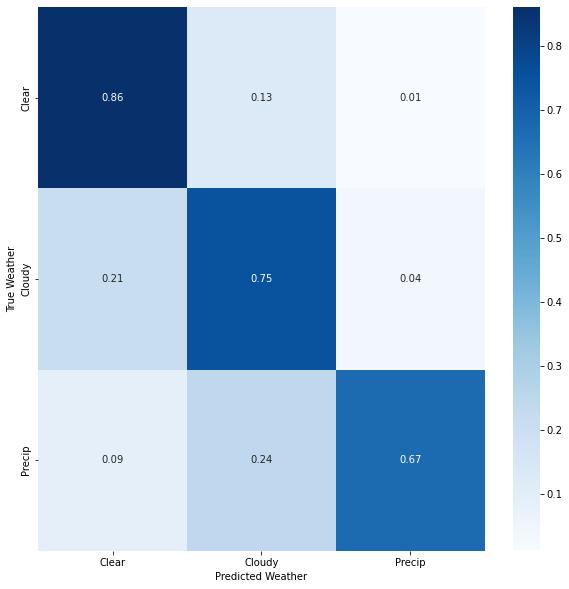

In [263]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

colormap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 10))
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, fmt=".2f")
ax.set_ylabel('True Weather');
ax.set_xlabel('Predicted Weather');
ax.set_xticklabels(wtype);
ax.set_yticklabels(wtype);
plt.show()

In [264]:
for i in range(len(wtype)):
    print('True positive rate for ' + wtype[i] + ' is ' + str(conf_matrix[i][i]))
print('')
print('Probability of predicting rain, given true weather is clear, is ' + str(conf_matrix[0][2]))

True positive rate for Clear is 0.8607954545454546
True positive rate for Cloudy is 0.7497603068072867
True positive rate for Precip is 0.6660323501427212

Probability of predicting rain, given true weather is clear, is 0.010416666666666666


([<matplotlib.axis.YTick at 0x231c53b2f88>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10'),
  Text(0, 11, '11'),
  Text(0, 12, '12'),
  Text(0, 13, '13'),
  Text(0, 14, '14'),
  Text(0, 15, '15'),
  Text(0, 16, 'Latitude'),
  Text(0, 17, 'Elevation'),
  Text(0, 18, 'Temperature'),
  Text(0, 19, 'Visibility'),
  Text(0, 20, 'WindSpeed'),
  Text(0, 21, 'Pressure'),
  Text(0, 22, 'Humidity')])

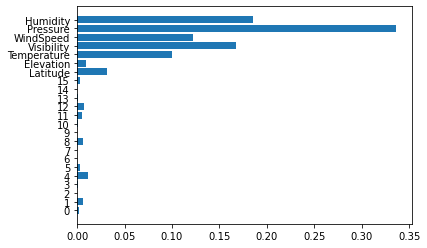

In [265]:
#Given plotting example for feature importance
plt.barh(range(23), rf.feature_importances_)
plt.yticks(range(23), list(range(16))+features[:-1])

#### 8. Standardise the relevant features (0.5 mark)

_Note:_ You shouldn't standardise the one-hot encoded wind directions; they already have the desired format. Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
- Hint:

    - Use the scikit-learn `StandardScaler`
    - Or use the scikit-learn `MinMaxScaler`

- Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
    - The number of columns should match, and depending on the choice of standardisation, the last 7 columns should either have:
      - (Using `StandardScaler`) means = 0 and standard deviations = 1; or
      - (Using `MinMaxScaler`) min = 0, max = 1

In [266]:
ct = ColumnTransformer([("scale", StandardScaler(), features[:-1])], remainder='passthrough')
sample_scaled = pd.DataFrame(ct.fit_transform(sample))
sample_scaled.columns = features[:-1] + list(range(16)) + output
sample_scaled.describe()

C:\Users\Matthew\Anaconda3\envs\daml\lib\site-packages\sklearn\utils\validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Latitude,Elevation,Temperature,Visibility,WindSpeed,Pressure,Humidity,0,1,2,...,7,8,9,10,11,12,13,14,15,Type
count,1.050000e+04,1.050000e+04,1.050000e+04,1.050000e+04,1.050000e+04,1.050000e+04,1.050000e+04,10500.000000,10500.000000,10500.000000,...,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000
mean,2.045280e-13,-4.330927e-17,-9.917823e-15,-7.579123e-17,-8.661854e-17,-2.338701e-15,-4.304942e-14,0.078190,0.070571,0.043524,...,0.040762,0.091524,0.042571,0.049048,0.078762,0.071429,0.079905,0.039524,0.067143,1.000000
std,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,0.268484,0.256120,0.204043,...,0.197748,0.288366,0.201898,0.215978,0.269380,0.257552,0.271159,0.194847,0.250281,0.816535
min,-1.886305e+00,-1.029889e+00,-3.648023e+00,-1.213670e+00,-1.303933e+00,-7.475503e+00,-4.002378e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.601435e-01,-8.210833e-01,-7.002490e-01,-8.295090e-01,-7.921979e-01,-6.320814e-02,-5.664767e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-6.332517e-02,-3.222686e-01,-9.335442e-02,-2.895243e-01,-1.098849e-01,3.169095e-01,2.868350e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6.558707e-01,4.897554e-01,6.291391e-01,6.361636e-01,4.018499e-01,5.069684e-01,8.154352e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,2.684352e+00,3.123033e+00,3.374615e+00,4.570338e+00,6.883823e+00,2.027439e+00,1.102390e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [267]:
X = sample_scaled.iloc[:, :-1].values
y = sample_scaled.iloc[:, -1].values.flatten()

#### 9. Split the dataset into a training and a testing part (0.5)

Reserve **30%** of data for testing. Check whether the resulting arrays have the expected shapes.

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7350, 23) (3150, 23) (7350,) (3150,)


## 3. Neural networks in `scikit-learn` (1.5 mark)
---
This section covers **2** exercises on constructing and training neural networks using the `scikit-learn` library, as well as evaluating neural network performance. `scikit-learn` provide many, very easy to use ML algorithms, including neural networks. These are called `MLPClassifier` (MLP = multi-layer perceptron; a historic name for densely connected, feed-forward neural networks) when used for classification, and `MLPRegressor` when used for regression. We will focus on the former for now.

In [269]:
# Relevant import(s) for this section
from sklearn.neural_network import MLPClassifier


#### 10. Construct and train a neural network  (1 mark)

- Create an `MLPClassifier` which
    - has **1 hidden layer of 50 neurons** 
    - has **no regularization term**
    - trains for a maximum of **100 epochs** 
    - uses a batch size of **32**
- Fit the classifier using the standard `.fit()` member method.
- Plot the loss function value as a function of number of epochs (0.5 of mark).
  You can access the loss history through the `.loss_curve_` attribute of the `MLPClassifier` instance. 

In [270]:
clf = MLPClassifier(max_iter=100, alpha=0, hidden_layer_sizes=(50,), batch_size=32)
clf.fit(X_train, y_train)

MLPClassifier(alpha=0, batch_size=32, hidden_layer_sizes=(50,), max_iter=100)

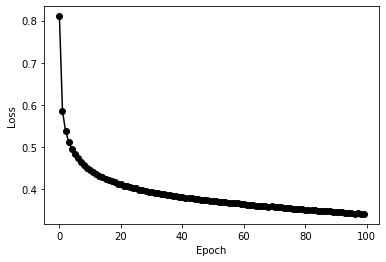

In [271]:
plt.plot(range(len(clf.loss_curve_)), clf.loss_curve_, '-ok')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#### 11. Performance evaluation (0.5 mark)

- Using the testing dataset: 
    - Compute the overall accuracy for the classifier using the `MLPClassifier`'s `.score()` member method for both testing and training datasets.
    - Compute the confusion matrix (normalised in true labels), and plot it 
- Discuss the results

In [272]:
print("Accuracy Training:",clf.score(X_train, y_train))
print("Accuracy Testing:",clf.score(X_test, y_test))

Accuracy Training: 0.8668027210884354
Accuracy Testing: 0.8238095238095238


## 4. Neural networks in `Keras` (2 marks)
---
This section covers **2** exercises on constructing and training neural networks using the `Keras` library. `scikit-learn` is very easy to use, but libraries like `Keras` provide a lot more flexibility, which is why we will be using these extensively in the last two units of the _'Data science tools and machine learning'_ track.

In [273]:
# Relevant import(s) for this section
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense

#### 12. Construct a neural network in `Keras` (1 mark)

- Create a `keras.Model` using the **Keras functional API**. The network should have:
    - An input layer with the same number of nodes as the number of features in `X`.
    - A single, densely connected hidden layer with **50 nodes** equipped with **ReLU activation**.
    - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
- Compile the model the using the **Adam optimiser**, add `'accuracy'` as metric, and use either:
    - `categorical_crossentropy` loss, if you have one-hot encoded the targets `y`, or
    - `sparse_categorical_crossentropy` loss if you hare using integer-valued targets.
- Use the `.summary()` member method to print an overview of the model you have created, explain the output.

In [274]:
input = Input(shape=(len(X_train[0]),))
h = Dense(50, activation='relu')(input)
output = Dense(3, activation='softmax')(h)
model = Model(input, output)
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                1200      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 153       
Total params: 1,353
Trainable params: 1,353
Non-trainable params: 0
_________________________________________________________________


The first column displays the input, hidden (dense) and output (dense) layers as were defined. The middle column shows (None, 50) meaning the hidden layer accepts sequences of any batch size in length but fixed 50 dimensional vectors corresponding to the 50 nodes in that layer. The last column is the number of trainable parameters by layer, for the output layer this is the $3 \times 50$ weights plus $3$ biases $= 150$. Finally, also displayed is the total number of trainable parameters of all layers. 

#### 13. Train a `Keras` neural network (1 mark)

- Use the `.fit()` member method to train the network on the **training dataset** for **100 epochs** with a **batch size of 32**. Use **20% of the data for validation** and make sure to have `Keras` **shuffle** the training data between epochs. Save the fit history by doing `history_mld = .....`
- Print the classification accuracy using the `.evaluate()` member method, for both the training and testing dataset. Comment on the results.
- Plot val_loss and loss functions from the fit history. On the same plot, plot the sklearn curve from the excercise above. Note the sklearn NN does not provide a complementary validation loss history, so only plot the training loss.
- Comment on the results of the overall accuracy compared to the scikit-learn method.

In [275]:
model_history = model.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

Train on 5880 samples, validate on 1470 samples
Epoch 1/100
5880/5880 [==============================] - 0s 56us/sample - loss: 0.8057 - acc: 0.6459 - val_loss: 0.6514 - val_acc: 0.7456
Epoch 2/100
5880/5880 [==============================] - 0s 43us/sample - loss: 0.5990 - acc: 0.7675 - val_loss: 0.5844 - val_acc: 0.7667
Epoch 3/100
5880/5880 [==============================] - 0s 40us/sample - loss: 0.5518 - acc: 0.7806 - val_loss: 0.5547 - val_acc: 0.7755
Epoch 4/100
5880/5880 [==============================] - 0s 39us/sample - loss: 0.5280 - acc: 0.7927 - val_loss: 0.5321 - val_acc: 0.7830
Epoch 5/100
5880/5880 [==============================] - 0s 46us/sample - loss: 0.5112 - acc: 0.8009 - val_loss: 0.5201 - val_acc: 0.7959
Epoch 6/100
5880/5880 [==============================] - 0s 42us/sample - loss: 0.4979 - acc: 0.8044 - val_loss: 0.5065 - val_acc: 0.8000
Epoch 7/100
5880/5880 [==============================] - 0s 46us/sample - loss: 0.4870 - acc: 0.8099 - val_loss: 0.4955 - va

5880/5880 [==============================] - 0s 37us/sample - loss: 0.3593 - acc: 0.8585 - val_loss: 0.4392 - val_acc: 0.8197
Epoch 60/100
5880/5880 [==============================] - 0s 34us/sample - loss: 0.3585 - acc: 0.8592 - val_loss: 0.4439 - val_acc: 0.8190
Epoch 61/100
5880/5880 [==============================] - 0s 37us/sample - loss: 0.3580 - acc: 0.8600 - val_loss: 0.4433 - val_acc: 0.8218
Epoch 62/100
5880/5880 [==============================] - 0s 38us/sample - loss: 0.3563 - acc: 0.8622 - val_loss: 0.4405 - val_acc: 0.8197
Epoch 63/100
5880/5880 [==============================] - 0s 47us/sample - loss: 0.3548 - acc: 0.8619 - val_loss: 0.4401 - val_acc: 0.8177
Epoch 64/100
5880/5880 [==============================] - 0s 34us/sample - loss: 0.3549 - acc: 0.8609 - val_loss: 0.4403 - val_acc: 0.8197
Epoch 65/100
5880/5880 [==============================] - 0s 34us/sample - loss: 0.3537 - acc: 0.8607 - val_loss: 0.4390 - val_acc: 0.8238
Epoch 66/100
5880/5880 [================

In [276]:
res_loss_train, accuracy_train = model.evaluate(X_train, y_train)
res_loss_test, accuracy_test = model.evaluate(X_test, y_test)
print("Accuracy Training:",accuracy_train)
print("Accuracy Testing:",accuracy_test)

3150/3150 [==============================] - 0s 27us/sample - loss: 0.4417 - acc: 0.8219
Accuracy Training: 0.8644898
Accuracy Testing: 0.8219048


## 5. Regularisation (1.5 marks)
---
This section covers **2** exercises on the impact of weight regularisaton. Note that $L_{1}$- and $L_{2}$-regularisation may also be applied to the activation of intermediate layers. Also, a similar regularising effect could be achieved using **dropout** regularisation, which you are encouraged to try out, but which we won't study in this CP exercise.

In [32]:
# Relevant import(s) for this section
from tensorflow.python.keras.regularizers import l1_l2

#### 14. Define `Keras` model factory method (0.5 mark)

- Define a python function called `big_model_fn` which takes the followng three arguments:
    - `l1`: A float specifying the $L_{1}$ regularisation factor (default value: 0)
    - `l2`: A float specifying the $L_{2}$ regularisation factor (default value: 0)
    - `name`: A string, specifying the name of the model (default value: None)
- Indside the function, you should:
    - Construct a `Keras` model using the functional API, which has:
        - An input layer with the same number of nodes as the number of features in `X`.
        - **Two** densely connected hidden layer with **100 nodes** each, both equipped with **ReLU activation**.
        - Both hidden layers should be subject to kernel regularisation (_i.e._ weight regularisation) with the regularisation factors specified as an input.
        - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
        - A name given by the corresponding argument.
    - Compile the model in the same way as in **Exercise 14.**
- The function should return the compiled `Keras` model. 

The method will provide a convenient way of constructing and compiling a number of "big"/deep `Keras` models which differ only by their regularisation and name.

#### 15. Train "big" models with and without regularisation (1 mark)

- Construct three "big" model using the factory method:
     - One with default parameters
     - One with `l1=0.0003` and  `name='Big model (L1-regularised)'`
     - One with `l2=0.003`  and `name='Big model (L2-regularised)'`
- Train each one as in **Exercise 15.**
- Compare first the loss history of the un-regularised "big" model to that of the small model from **Exercise 15** using the `plot.loss()` method.
- Then, compare the loss histories of all three "big" models with that of the small model.
- Plot the loss and val loss of all 4 models and discuss the results. Target these points:
    - Compare the performance of deep vs shallow models on the testing sets
    - Compare the level of ovetraining (training vs testing loss)
    - Note: Don't be alarmed if the shallow network performs slightly better that the deeper ones, this is dataset dependant.

## 6. Bonus: Hyperparameter optimisation (1\*bonus\* mark)
---

This section covers **1** exercise on the on hyperparameter optimisation. 

In [38]:
# Relevant import(s) for this section
from sklearn.model_selection import GridSearchCV, cross_val_score

---
_**Comment on simplified hyperparameter optimisation example:**_ You will try to perform a simple optimisation using a grid search

For convenience, we will be using the `scikit-learn` `MLPClassifier` as our base class, but the same principles apply to just about any ML model constructed in any framework. Just as in the examples in the lecture, we will restrict the hyperparameter space to just two dimensions:

* the number of hidden layers, `nb_layers`, and
* the number of nodes per hidden layer, `nb_nodes_per_layer`, which is taken to be the same for all hidden layers for simplicity.

Since the `scikit-learn` neural network classifier class doesn't support these two hyperparameters by default, provided is a simple wrapper class, that works exactly like `MLPClassifier`, it just takes the two parameters above as arguments in the constructor. Don't worry about understanding it in detail. This allows us to call 

In [39]:
class MLPClassifierWrapper(MLPClassifier):
    """
    Wrapper around `sklearn.neural_network.MLPClassifier` with a convenient set 
    of properties (nb_layers and nb_nodes_per_layer) suitable for hyperparameter 
    optimisation exercises.
    
    Arguments:
        nb_layers: Integer, number of hidden layers
        nb_nodes_per_layer: Number of nodes per hidden layer, taken to be the 
            same for all for convenience.
    """

    def __init__ (self, nb_layers=1, nb_nodes_per_layer=100, **kwargs):
        
        # Member variables
        self._nb_layers = nb_layers
        self._nb_nodes_per_layer = nb_nodes_per_layer  
        
        # Call base class (`MLPClassifier`) constructor
        super(MLPClassifierWrapper, self).__init__(**kwargs)
        
        # Trigger `_set_architecture`
        self._set_architecture()
        return

    @property
    def nb_layers(self):
        return self._nb_layers
    
    @property
    def nb_nodes_per_layer(self):
        return self._nb_nodes_per_layer 

    @nb_layers.setter
    def nb_layers(self, value):
        self._nb_layers = value
        self._set_architecture()
        return
    
    @nb_nodes_per_layer.setter
    def nb_nodes_per_layer(self, value):
        self._nb_nodes_per_layer = value
        self._set_architecture()
        return
    
    def _set_architecture (self):
        """
        Sets the `hidden_layer_sizes` parameter of the base `MLPClassifier` 
        class, based on the two custom parameters we have chosen.
        """
        
        self.hidden_layer_sizes = tuple([self._nb_nodes_per_layer for _ in range(self._nb_layers)])
        return
    pass

---

#### 16. Perform a grid search (1 mark)

- Construct a python `dict` called `param_grid` which specifies the hyperparameter configurations to try for each parameter dimension. That is, it should have
    - `"nb_layers"` and `"nb_nodes_per_layer"` as keys, and
    - lists of integers as values, corresponding to the values of each parameter you want to try out (_e.g._ [1, 2, ...])
- Choose a reasonable set of values for each parameter; about a handful for each.
- Use the `GridSearchCV` class to perform _**3**_**-fold** cross validation (CV) optimisation of the validation **accuracy**
    - Hint: You can use the `n_jobs=...` argument to enable multi-processing, thereby speeding up the optimisation, at the expense of reproducibility.
- The base classifier should be an instance of `MLPClassifierWrapper` set to train for **100 epochs**.
- Present the results:
    - Print the best parameter configuration found. GridSearchCV has a public member which stores this. Read doc.
    - Print the mean and standard deviation of the test scores for the best configuration found. (_Hint:_ These can be found in the `.cv_results_` attribute)
    - Plot the optimisation results using the `plot.optimisation` method.
- Discuss the results. What would happen if the best result is foundon the edge of the parameter grid?